In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px grey solid !important;
  color: white !important;
}
</style>

In [42]:
import os
import re
import emoji
import demoji
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# processing of text
import stanza
import spacy
import text_functions as text_f
from stopwords import stopwords
from pyMorfologik import Morfologik

#plot
from plot_functions import plot_word_cloud, count_plot_words

# models
import torch
import lazypredict
import xgboost
from model_functions import train_validation_test_split

# setting display
pd.options.mode.chained_assignment = None
pd.options.display.max_colwidth = 300
pd.set_option("display.colheader_justify","left")
%matplotlib inline

# load and download
demoji.download_codes()
spacy_pl = spacy.load('pl_spacy_model')

... OK (Got response in 0.50 seconds)
Writing emoji data to C:\Users\patry\.demoji\codes.json ...
... OK


In [79]:
data_poleval_raw = pd.read_csv('Labeled_data/converted_label_poleval.txt', 
                           error_bad_lines=False, sep=",")
data_poleval_test_raw = pd.read_csv('Labeled_data/converted_label_poleval_test.txt', 
                           error_bad_lines=False, sep=",")
data_github_raw = pd.read_csv('Labeled_data/labeled_dataset.txt', 
                          error_bad_lines=False, sep="|")

data_poleval = data_poleval_raw.copy(deep=True)
data_poleval_test = data_poleval_test_raw.copy(deep=True)
data_github = data_github_raw.copy(deep=True)
datasets = [data_poleval, data_poleval_test, data_github]

conected_data = pd.concat([data_poleval, 
                           data_poleval_test, 
                           data_github.drop(['No', 'Yes'], 
                                            axis=1)], 
                          axis=0, 
                          ignore_index=True)

In [6]:
for data in datasets:
    display(data.head(20))

,Comment,Kind of offensive language
0,"Dla mnie faworytem do tytułu będzie Cracovia. Zobaczymy, czy typ się sprawdzi.",0
1,@anonymized_account @anonymized_account Brawo ty Daria kibic ma być na dobre i złe,0
2,"@anonymized_account @anonymized_account Super, polski premier składa kwiaty na grobach kolaborantów. Ale doczekaliśmy czasów.",0
3,@anonymized_account @anonymized_account Musi. Innej drogi nie mamy.,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0
5,"Jaki on był fajny xdd pamiętam, że spóźniłam się na jego pierwsze zajęcia i to sporo i za karę kazał mi usiąść w pierwszej ławce XD",0
6,@anonymized_account No nie ma u nas szczęścia 😉,0
7,@anonymized_account Dawno kogoś tak wrednego nie widziałam xd,0
8,"@anonymized_account @anonymized_account Zaległości były, ale ważne czy były wezwania do zapłaty z których się klub nie wywiązał.",0
9,@anonymized_account @anonymized_account @anonymized_account Gdzie jest @anonymized_account . Brudziński jesteś kłamcą i marnym kutasem @anonymized_account,1


,Comment,Kind of offensive language
0,"@anonymized_account Spoko, jak im Duda z Morawieckim zamówią po pięć piw to wszystko będzie ok.",0
1,"@anonymized_account @anonymized_account Ale on tu nie miał szans jej zagrania, a ta 'proba' to czysta prowizorka.",0
2,"@anonymized_account No czy Prezes nie miał racji, mówiąc,ze to są zdradzieckie mordy? No czy nie miał racji?😁😁",0
3,@anonymized_account @anonymized_account Przecież to nawet nie jest przewrotka 😂,0
4,@anonymized_account @anonymized_account Owszem podatki tak. Ale nie w takich okolicznościach. Czemu Małysza odpalili z teamu Orlen?,0
5,@anonymized_account @anonymized_account skąd wiesz jaki Skendija ma budżet skoro mówisz że jest bogatsza ? Tylko dwóch zawodników ponoć dobrze zarabia.,0
6,"Z tego, co widzę, to kibice Widzewa mają szczęście, że trwa mundial. Dzięki temu ogólnopolska szydera jest tylko z Argentyny i Messiego.",0
7,"@anonymized_account @anonymized_account @anonymized_account Na utrzymanie własnej armii 2% PKB, tyle że teraz to jedna wielka ściema",0
8,Przypomnijcie mi ze muszę jeszcze suszarkę spakować,0
9,"Czy Adam już nie żyje? Jeśli tak, to jak rozwiązali jego wątek? #nadobreinazłe",0


,Comment,No,Yes,Kind of offensive language
0,"Dziwię się, że Niemcy działają opieszale w sprawie gwałtów przecież nie wyszli chyba z wprawy z radykalnych rozwiązań tzn. w obozach dla tych islamskich zwierząt instalować przewoźne komory gazowe i po problemie.",3,28,2
1,Przywalić atomem tej islamskiej dziczy. Merkel powinna być powieszona publicznie.,2,7,2
2,"Tu trzeba jasno powiedzieć,wracasz albo kulka.",0,40,2
3,umrzesz za tydzień,16,0,2
4,"wybic do nogi prawie wszystkich arabów , pozostawiając kilku jako eksponaty",1,1,2
5,SPALIĆ MECZETY,1,1,2
6,"Czas odpalic piece i komory gazowe, szybko zboczencow muzulmanskich osądzać i w dym obracać.",1,14,2
7,Stryczek !,11,4,2
8,Bohater narodowy szkalowany przez prawicę która tylko nienawidzi! Śmierć popierającym PiS to antyludzie!,4,2,2
9,Proponuję wysłać do niego pluton specjalny z polonem.,12,6,2


In [7]:
data_github['Kind of offensive language'].value_counts().to_frame()\
    .rename_axis('Response', axis=1).style.set_properties(
        **{'color': 'white !important',
           'border': '1px grey solid !important',
           'text-align': 'center'}
        ).set_table_styles([{
            'selector': 'th',
            'props': [('border', '1px grey solid !important')]
        }])

Response,Kind of offensive language
1,2305
2,43


Due to only two response "1" and "2" we reject column 'no' and 'yes' because this columns don't give us necessary information.

In [8]:
data_github.drop(['No', 'Yes'], axis=1, inplace=True)

In [9]:
data_github.head()

,Comment,Kind of offensive language
0,"Dziwię się, że Niemcy działają opieszale w sprawie gwałtów przecież nie wyszli chyba z wprawy z radykalnych rozwiązań tzn. w obozach dla tych islamskich zwierząt instalować przewoźne komory gazowe i po problemie.",2
1,Przywalić atomem tej islamskiej dziczy. Merkel powinna być powieszona publicznie.,2
2,"Tu trzeba jasno powiedzieć,wracasz albo kulka.",2
3,umrzesz za tydzień,2
4,"wybic do nogi prawie wszystkich arabów , pozostawiając kilku jako eksponaty",2


In [80]:
conected_data = text_f.remove_quoting_comments(conected_data)
conected_data.head(50)

,Comment,Kind of offensive language
0,"Dla mnie faworytem do tytułu będzie Cracovia. Zobaczymy, czy typ się sprawdzi.",0
1,@anonymized_account @anonymized_account Brawo ty Daria kibic ma być na dobre i złe,0
2,"@anonymized_account @anonymized_account Super, polski premier składa kwiaty na grobach kolaborantów. Ale doczekaliśmy czasów.",0
3,@anonymized_account @anonymized_account Musi. Innej drogi nie mamy.,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0
5,"Jaki on był fajny xdd pamiętam, że spóźniłam się na jego pierwsze zajęcia i to sporo i za karę kazał mi usiąść w pierwszej ławce XD",0
6,@anonymized_account No nie ma u nas szczęścia 😉,0
7,@anonymized_account Dawno kogoś tak wrednego nie widziałam xd,0
8,"@anonymized_account @anonymized_account Zaległości były, ale ważne czy były wezwania do zapłaty z których się klub nie wywiązał.",0
9,@anonymized_account @anonymized_account @anonymized_account Gdzie jest @anonymized_account . Brudziński jesteś kłamcą i marnym kutasem @anonymized_account,1


In [11]:
# prepare to function to extract emoji to dict
emoji_for_response_0 = []
emoji_for_response_1 = []
emoji_for_response_2 = []

In [12]:
conected_data['Emoticons'], conected_data['Number of emoticons in comment'] = \
    zip(*conected_data[['Comment', 'Kind of offensive language']].apply(\
                                       text_f.extract_emoticons, axis=1,
                                       args=(emoji_for_response_0,
                                            emoji_for_response_1,
                                            emoji_for_response_2)))

In [13]:
dict_count_emoji_0 = dict((i, emoji_for_response_0.count(i)) for i in
                          emoji_for_response_0)
dict_count_emoji_1 = dict((i, emoji_for_response_1.count(i)) for i in
                          emoji_for_response_1)
dict_count_emoji_2 = dict((i, emoji_for_response_2.count(i)) for i in
                          emoji_for_response_2)

In [14]:
conected_data[(conected_data['Kind of offensive language'] == 2) 
              & (conected_data['Number of emoticons in comment']>0)]

,Comment,Kind of offensive language,Emoticons,Number of emoticons in comment
1472,"@anonymized_account @anonymized_account Jaka tv, tacy idole😁😁😁 A tak trochę poważniej, to za tę napaść na dziewczynkę to tylko w ten pedalski ryj.",2,😁,3
1949,"@anonymized_account Zamknij niemiecki ryj,siedź w tej Brukseli i nie wracaj złodzieju!😬😬😬",2,😬,3


In [15]:
plot_emoticons = text_f.create_dataframe_emoji_comparison(dict_count_emoji_0,
                                                   dict_count_emoji_1,
                                                   dict_count_emoji_2,
                                                   ['Response_0', 'Response_1'])
plot_emoticons

,Response_0,Response_1,Response_2
emoji,,,
😁,850.0,67.0,3.0
:),743.0,42.0,NaN
😂,626.0,33.0,NaN
xd,199.0,6.0,NaN
😀,167.0,9.0,NaN
😉,161.0,NaN,NaN
;-),127.0,1.0,NaN
:d,93.0,3.0,NaN
;),88.0,10.0,NaN


In [81]:
conected_data['Comment'] = conected_data['Comment'].apply(lambda x: emoji.demojize(x))
# conected_data['Comment'] = text_f.preprocess_text(conected_data['Comment'])

In [82]:
def preprocess_text(data: pd.Series, tokenizer=False, stopwords_remove=False):
    # remove of @name
    pattern = re.compile(r'@\w+\s')
    data = data.str.replace(pattern, '')

    # remove of links https
    pattern = re.compile(r"https?[:\/\/]+[a-zA-Z0-9.\-\/?=_~:#%]+")
    data = data.str.replace(pattern, '')

    # removal of punctuations and numbers
    pattern = re.compile(r'[^_ąćęłńóśźżĄĆĘŁŃÓŚŹŻa-zA-Z\s]')
    data = data.str.replace(pattern, '')

    # remove more than one space
    pattern = re.compile(r'\s+')
    data = data.str.replace(pattern, ' ')

    # remove beginning and ending task space
    pattern = re.compile(r'^\s+|\s+?$')
    data = data.str.replace(pattern, '')

    # removal of capitalization
    data = data.str.lower()

    # tokenizing
    if tokenizer:
        data = data.apply(lambda x: x.split())
    if stopwords_remove:
        data = data.apply(
            lambda x: [item for item in x if item not in stopwords])

    if tokenizer or stopwords_remove:
        for i in range(len(data)):
            data[i] = ' '.join(data[i])
#             tweets_p = data
    print(data)
    print('-----')
    return data


In [85]:
conected_data['Comment'] = preprocess_text(conected_data.iloc[:2]['Comment'], tokenizer=True, stopwords_remove=True)

0    faworytem tytułu cracovia zobaczymy typ sprawdzi
1                         brawo daria kibic dobre złe
Name: Comment, dtype: object
-----


In [86]:
conected_data

,Comment,Kind of offensive language
0,faworytem tytułu cracovia zobaczymy typ sprawdzi,0
1,brawo daria kibic dobre złe,0
2,NaN,0
3,NaN,0
4,NaN,0
...,...,...
12675,NaN,1
12676,NaN,1
12677,NaN,1
12678,NaN,1


In [18]:
conected_data = conected_data[['Comment', 'Kind of offensive language']]
conected_data.to_csv('data_for_model.csv', index=False)

In [19]:
conected_data

,Comment,Kind of offensive language
0,dla mnie faworytem do tytułu będzie cracovia zobaczymy czy typ się sprawdzi,0
1,brawo ty daria kibic ma być na dobre i złe,0
2,super polski premier składa kwiaty na grobach kolaborantów ale doczekaliśmy czasów,0
3,musi innej drogi nie mamy,0
4,odrzut natychmiastowy kwaśna mina mam problem,0
...,...,...
12675,nie mam problemu z prześwitującą bluzką ale tu to jakoś wszystko po prostu kiepsko wyglądamało zgrabnie,1
12676,piękna twarz oszpecona wyskubanymi włosami lustra nie ma ujęła sobie tym kobiecości,1
12677,szkoda ze miała stanik mam nadziej że w przyszłym programie nie będzie go miała,1
12678,przede wszystkim źle dobrany biustonosz a spódniczka też trochę za wąska wystarczy celebrytko obejrzeć się w lustrze aby zobaczyć o czym piszę,1


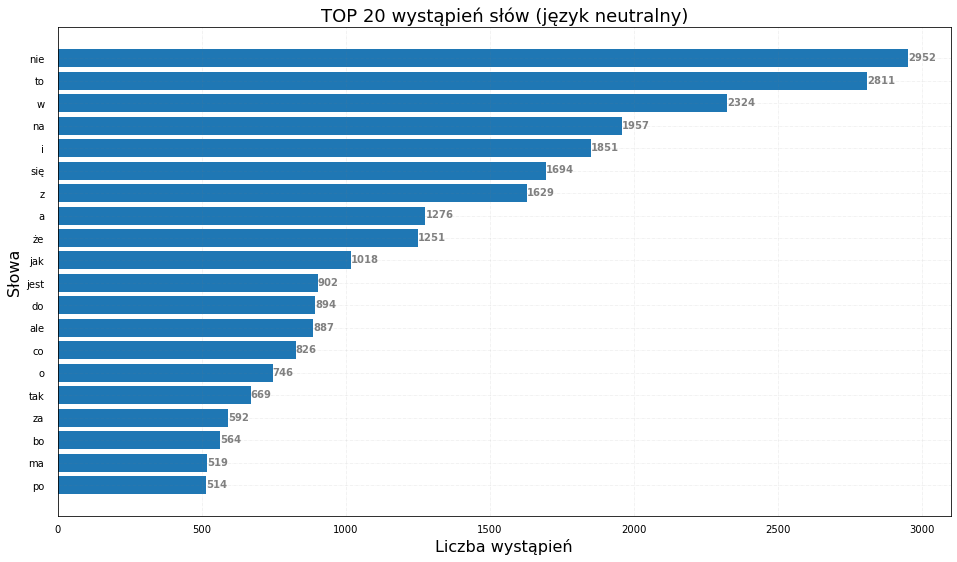

In [25]:
count_plot_words(kind_0, 'język neutralny')

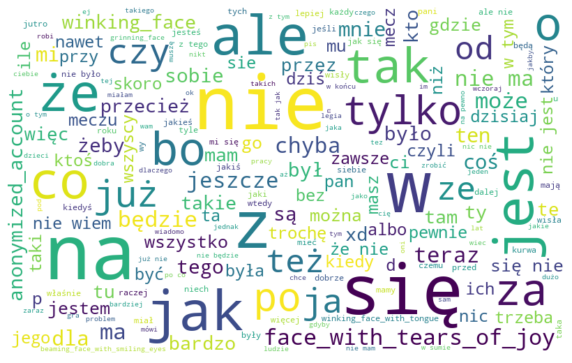

In [28]:
# visualizing which of the word is most commonly used
kind_0 = conected_data[conected_data['Kind of offensive language']==0]
plot_word_cloud(kind_0)
plot_word_cloud(kind_0, stopwords=stopwords)

In [ ]:
# visualizing which of the word is most commonly used
kind_1 = conected_data[conected_data['Kind of offensive language']==1]
plot_word_cloud(kind_1)
plot_word_cloud(kind_1, stopwords=stopwords)

In [ ]:
# visualizing which of the word is most commonly used
kind_2 = conected_data[conected_data['Kind of offensive language']==2]
plot_word_cloud(kind_2)
plot_word_cloud(kind_2, stopwords=stopwords)

# Model

In [ ]:
data_train, data_validate, data_test = train_validation_test_split(conected_data, random_state=101)

In [ ]:
data_train['Kind of offensive language'].value_counts()